In [1]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

def pz_plot(sys):
    if isinstance(sys, sig._ltisys.StateSpaceContinuous):
        ax = plt.gca()
        ax.set_aspect('equal')
        ax.plot(np.real(sys.zeros), np.imag(sys.zeros), 'C0o', markersize=8, linewidth=0, markerfacecolor='none')
        ax.plot(np.real(sys.poles), np.imag(sys.poles),'C0x', markersize=8, linewidth=0, markerfacecolor='none')
        width = np.max(np.imag(sys.poles))
        ax.set_ylim([-width*1.1, width*1.1])
        ax.set_xlim([-width*1.2, width])
        ax.spines["left"].set_position(("data", 0))
        ax.spines["bottom"].set_position(("data", 0))
        # Hide the top and right spines.
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_title('Pole zero map')

    elif isinstance(sys, sig._ltisys.StateSpaceDiscrete):
        ax = plt.gca()
        ax.set_aspect('equal')
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([-1.2, 1.2])
        ax.plot(np.real(sys.zeros), np.imag(sys.zeros), 'C0o', markersize=8, linewidth=0, markerfacecolor='none')
        ax.plot(np.real(sys.poles), np.imag(sys.poles),'C0x', markersize=8, linewidth=0, markerfacecolor='none')
        ax.plot(np.cos(np.linspace(0, 2*np.pi, 513)), np.sin(np.linspace(0, 2*np.pi, 513)),'k:')
        ax.set_title('Pole zero map')
        ax.set_xlabel(r'$\mathcal{Re}(z)$')
        ax.set_ylabel(r'$\mathcal{Im}(z)$')
    else:
        raise Exception("Input argument 'sys' not recognized as continuous or discrete LTI system")

%matplotlib ipympl

<img src="Figurer/NTNU_Logo.png" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Diskretisering i $z$-domenet

* **Emne AIS2102 - Dynamiske System**
* **Uke 8, 2025**
* **Underviser: Kai Erik Hoff**

# Tema
* Intro til diskretisering av transferfunksjoner
    - Case: derivator med støy
* Diskretisering med forward euler differanse
    - Polavbildning
* Diskretisering med backward euler differanse
    - Polavbildning
* Diskretisering med tustins metode
    - Polavbildning
    - Frekvensfordreining

# Case: *derivatorledd i PID kontroller*

* En digital enhet måler posisjonen $y$ til et objekt $f_s = 200$ ganger i sekundet


* Begrenset oppløsning fører til kvantisering av de diskretiserte posisjonsmålingene med trinnhøyde $q = 2\text{mm}$
    - $y[k] = p(t\cdot T_s) + w_q[k], \ \ \ \ \ w_q[k]\sim \mathcal{U}\left(-\frac{q}{2}, \frac{q}{2}\right)$

* Objektets hastighet estimeres med bakoverdifferanse:
$$ \dot{y}[k] \approx f_s \cdot \left(y[k] - y[k-1]\right)$$

* Hvordan ser estimert hastighet ut?

## Derivasjonsstøy illustrert


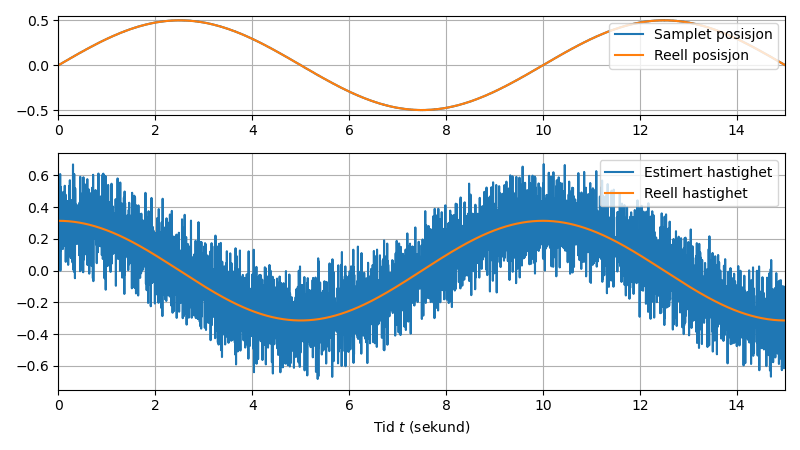

In [2]:
plt.close(1); plt.figure(1)

N = 3_000 # antall målinger totalt
q = 2e-3 # kvantiseringssteghøyde/oppløsning (mm) 
fs = 200 # samplingsfrekvens
T = N/fs

# teoretisk posisjonsdata og fartsdata
t = np.linspace(0.0, T, N, endpoint=False)
y_t = 0.5*sin(2*pi/10*t)
v_t = pi/10*cos(2*pi/10*t)

# Simuler målinger
w_q = np.random.rand(N)*q-q/2
y_k = y_t + w_q; # samplet signal = ekte signal pluss modellert kvantiseringsstøy

# Beregn bakoverdifferanse
v_k = np.diff(y_k)*fs


# Lag plot av målt posisjon og hastighetsestimat
plt.subplot(3,1,1)
plt.plot(t, y_k, label="Samplet posisjon")
plt.plot(t, y_t, label="Reell posisjon")
plt.legend(loc="upper right")

plt.subplot(3,1,(2,3))
plt.plot(t[1:], v_k, label="Estimert hastighet")
plt.plot(t, v_t, label="Reell hastighet")
plt.legend(loc="upper right")
plt.xlabel("Tid $t$ (sekund)")

plt.tight_layout()

## Lavpassfiltrert derivator

* Følger opp derivasjon med et lavpassfilter
$$s \cdot \frac{\omega_c}{s + \omega_c}$$

* Neste steg: *diskretiser transferfunksjonen til den lavpassfiltrerte derivatoren*

# Diskretisering av transferfunksjoner

* Gruppe disretiseringsmetoder der<br>
$$G(s) \big|_{s = f(z)} \rightarrow G(z)$$

* Ideell substitusjon: $z = e^{s \cdot T_s} \ \leftrightarrow \  s = \frac{\ln(z)}{T_s}$
    - Gir ikke transferfunksjonen/tilstandsrommodellen til et tidsdiskret LTI-system

* Vi må finne en approksimasjon!

# Forward Euler

* Tilnærming:
$$\dot{u}[k] \approx \frac{u[k+1] - u[k]}{T_s}$$

* Forward Euler i z-domenet:
$$G_{\text{diff}}(z) = \frac{1}{T_s}\cdot (z-1)$$

* Substitusjon:
$$ s \approx \frac{1}{T_s}\cdot (z-1)$$

# Forward Euler med Tilstandsrom:

* Utfører substitusjon $ s \approx \frac{1}{T_s}\cdot (z-1)$ i tilstandsrommodellen:
$$
\begin{align*}
    \frac{1}{T_s} \cdot (z-1) \cdot \boldsymbol{x} &= \boldsymbol{A} \cdot \boldsymbol{x} + \boldsymbol{B} \cdot \boldsymbol{u} \\
    \boldsymbol{y} &= \boldsymbol{C} \cdot \boldsymbol{x} + \boldsymbol{D} \cdot \boldsymbol{u}
\end{align*}
$$




* Algebraisk omregning gir:
\begin{align}
    \boldsymbol{A_d} &= (\boldsymbol{I} + \boldsymbol{A} \cdot T_s) \\
    \boldsymbol{B_d} &= T_s  \cdot \boldsymbol{B} \\
    \boldsymbol{C_d} &= \boldsymbol{C}\\
    \boldsymbol{D_d} &= \boldsymbol{D}
\end{align}

## Mapping av stabilitetsregion

<img src="Figurer/disc_methods/fwd_euler_map.svg" style="width: 80%" />

## Forward Euler med Python

/opt/conda/lib/python3.12/site-packages/scipy/signal/_filter_design.py:1125: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)
/opt/conda/lib/python3.12/site-packages/scipy/signal/_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


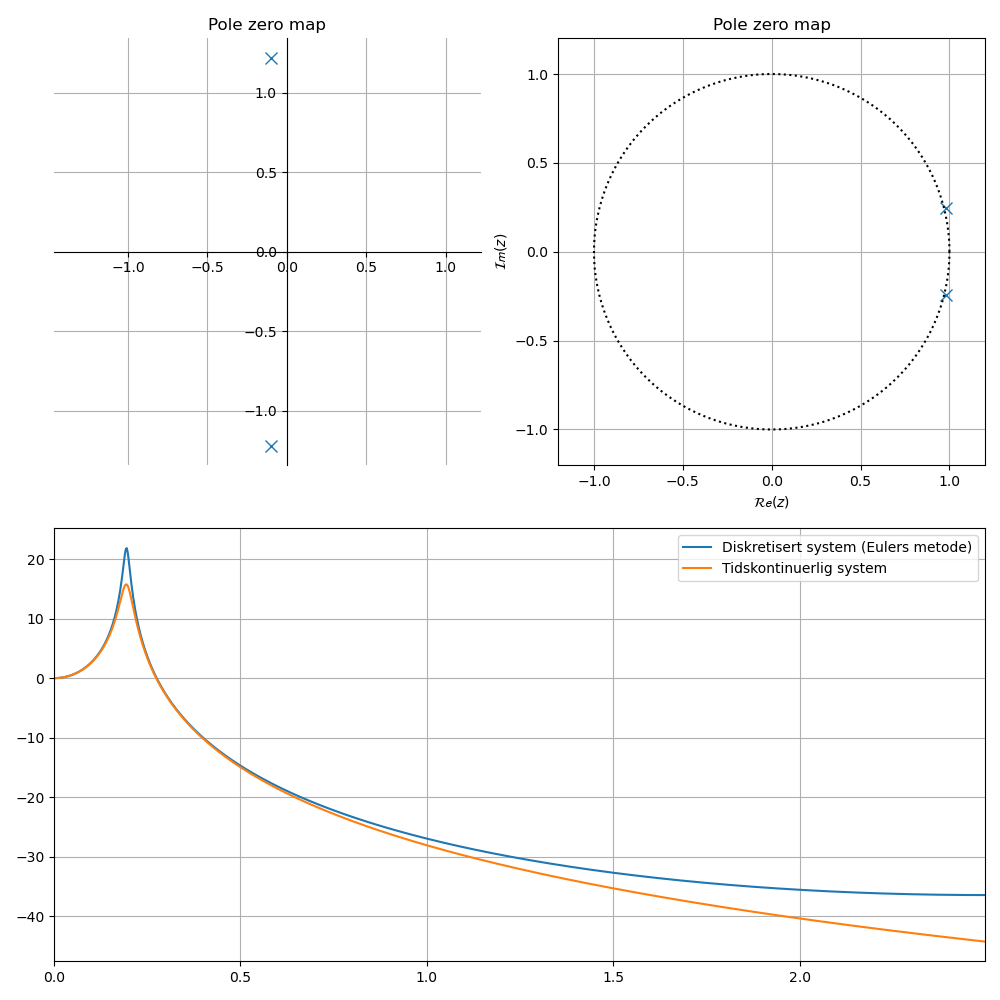

In [3]:
# Kontinuerlig system
A = np.array([[0, 1],
             [-1.5, -0.2]])
B = np.array([[0],
             [1.5]])
C = np.array([[1, 0]])
D = np.array([[0]])
sys = sig.StateSpace(A, B, C, D)

# Diskretisering
Ts = 0.2
A_d = np.eye(2) + Ts*A
B_d = Ts*B
C_d = C
D_d = D

sys_ex1 = sig.StateSpace(A_d, B_d, C_d, D_d, dt=Ts)

plt.close(2); plt.figure(2, figsize=(10,10))
#fig, axes = plt.subplots(2,2, num=2, clear=True)
plt.subplot(2,2,1)
pz_plot(sys)
plt.subplot(2,2,2)
pz_plot(sys_ex1)
plt.subplot(2,2,(3,4))
w, magd, _ = sys_ex1.bode(n=1001)
wc, magc, _ = sys.bode(w = w)
plt.plot(w/(2*pi), magd, label="Diskretisert system (Eulers metode)")
plt.plot(w/(2*pi), magc, label="Tidskontinuerlig system")
#plt.xscale("log")
plt.legend()


# Backward Euler

* Tilnærming:
$$\dot{u}[k] \approx \frac{u[k] - u[k-1]}{T_s}$$

* Backward Euler i z-domenet:
$$G_{\text{diff}}(z) = \frac{1}{T_s}\cdot \frac{z-1}{z}$$

* Substitusjon:
$$s \approx \frac{1}{T_s}\cdot \frac{z-1}{z}$$


* Førsteordens *implisitt* runge-kutta metode

# Backward Euler i tilstandsrom

* Utfører substitusjon $s \approx \frac{1}{T_s}\cdot \frac{z-1}{z}$ i tilstandsrommodellen:
$$
\begin{align*}
    \frac{1}{T_s} \cdot \frac{z - 1}{z} \cdot \boldsymbol{x} &= \boldsymbol{A} \cdot \boldsymbol{x} + \boldsymbol{B} \cdot \boldsymbol{u} \\
    \boldsymbol{y} &= \boldsymbol{C} \cdot \boldsymbol{x} + \boldsymbol{D} \cdot \boldsymbol{u}
\end{align*}
$$




* Algebraisk omregning gir:
\begin{align}
    \boldsymbol{A_d} &= (\boldsymbol{I} - \boldsymbol{A} \cdot T_s)^{-1} \\
    \boldsymbol{B_d} &= T_s \cdot (\boldsymbol{I} - \boldsymbol{A} \cdot T_s)^{-1} \cdot \boldsymbol{B} \\
    \boldsymbol{C_d} &= \boldsymbol{C} \cdot (\boldsymbol{I} - \boldsymbol{A} \cdot T_s)^{-1} \\
    \boldsymbol{D_d} &= \boldsymbol{D} + \boldsymbol{C} \cdot \boldsymbol{B_d}
\end{align}

## Mapping av stabilitetsregion

<img src="Figurer/disc_methods/back_euler_map.svg" style="width: 80%" />

## Backward Euler illustrert

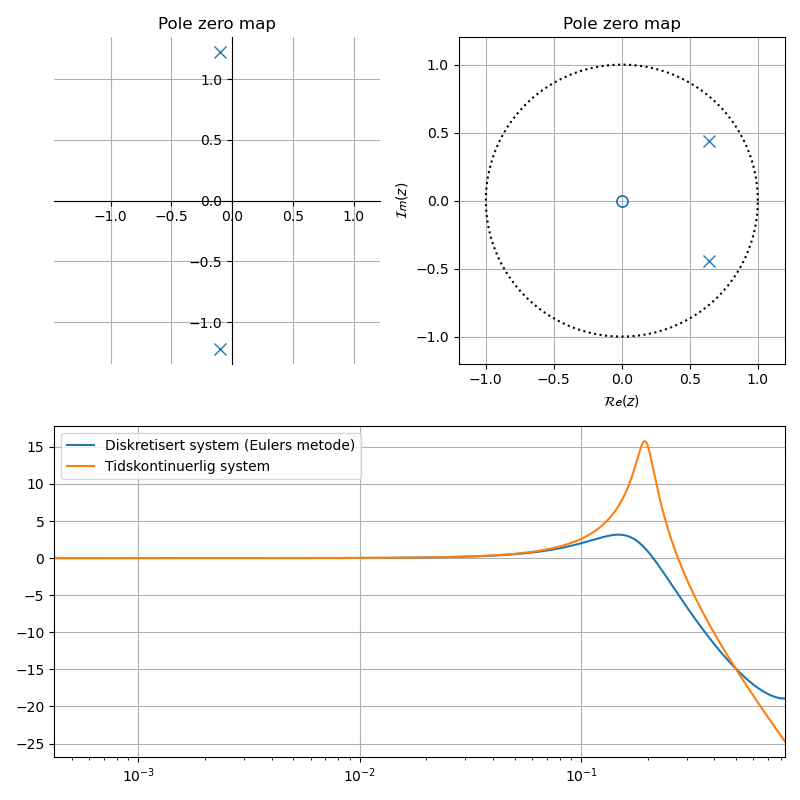

In [4]:
# Kontinuerlig system
A = np.array([[0, 1],
             [-1.5, -0.2]])
B = np.array([[0],
             [1.5]])
C = np.array([[1, 0]])
D = np.array([[0]])
sys = sig.StateSpace(A, B, C, D)

# Diskretisering (kan også utføres med scipy.signal.cont2discrete)
Ts = 0.6
A_d = np.linalg.inv(np.eye(2) - A*Ts)
B_d = Ts*A_d@B
C_d = C@A_d
D_d = D + C@B_d

sys_ex1 = sig.StateSpace(A_d, B_d, C_d, D_d, dt=Ts)

plt.close(3); plt.figure(3, figsize=(8,8))
#fig, axes = plt.subplots(2,2, num=2, clear=True)
plt.subplot(2,2,1)
pz_plot(sys)
plt.subplot(2,2,2)
pz_plot(sys_ex1)
plt.subplot(2,2,(3,4))
w, magd, _ = sys_ex1.bode(n=2001)
wc, magc, _ = sys.bode(w = w)
plt.plot(w/(2*pi), magd, label="Diskretisert system (Eulers metode)")
plt.plot(w/(2*pi), magc, label="Tidskontinuerlig system")
plt.xscale("log")
plt.legend()


<br><br><br><br>
# Tustins Metode

* Kjært barn har mange navn: Trapesmetoden, Bilineær Transformasjon.

# Trapesintegrasjon

<img src="Figurer/disc_methods/trapezoidal_int.png" style="width: 70%; margin-left: 100px" />

# Trapesintegrasjon

* Hvordan kan vi sette opp et LTI-system for å utføre trapesintegrasjon?

# Trapesintegrator som LTI-system

<img src="Figurer/disc_methods/trapezoidal_sys.png" style="width: 80%" />

# Trapesintegrasjon i $z$-domenet

* Tilnærming:
$$\int_0^{k\cdot T_s} u(t) dt   \approx \frac{u[k] + u[k-1]}{2}\cdot T_s + \int_0^{(k-1)\cdot T_s} u(t)dt$$

* Trapesintegrasjon i z-domenet:
$$G_{\text{int}}(z) = \frac{T_s}{2}\cdot \frac{z+1}{z-1}$$

* Substitusjon:
$$s \approx \frac{2}{T_s}\cdot \frac{z-1}{z+1}$$



* Andreordens *implisitt* runge-kutta metode

## Diskretisering av lavpassfiltrert derivator



* Vi utfører diskretisering av transferfunksjonen med tustins metode
$$G(s) = s\cdot \frac{\omega_c}{s + \omega_c}$$
    * Vi kan sette kantfrekvensen $\omega_c = 10 \text{rad/s}$ (basert på ønsket responstid for systemet)
    * $f_s = 50$ sampler per sekund

## Filtrert derivasjonsøy illustrert


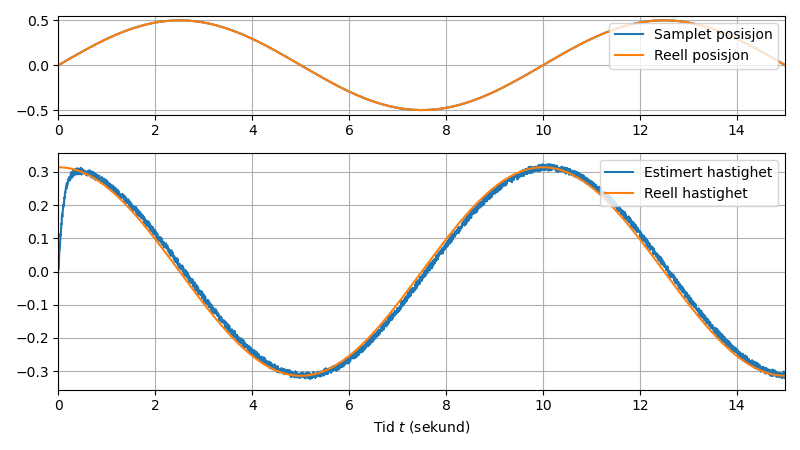

In [5]:
plt.close(4); plt.figure(4)

N = 3_000 # antall målinger totalt
q = 2e-3 # kvantiseringssteghøyde/oppløsning (mm) 
fs = 200 # samplingsfrekvens
Ts = 1/fs
T = N/fs

# teoretisk posisjonsdata og fartsdata
t = np.linspace(0.0, T, N, endpoint=False)
y_t = 0.5*sin(2*pi/10*t)
v_t = pi/10*cos(2*pi/10*t)

# Simuler målinger
w_q = np.random.rand(N)*q-q/2
y_k = y_t + w_q; # samplet signal = ekte signal pluss modellert kvantiseringsstøy

# Utfør filtrert derivasjon
w_c = 10 # Rad/s
b0 = 2*w_c/(Ts*w_c+2)
b1 = -b0
a0 = 1.0
a1 = (Ts*w_c-2)/(Ts*w_c+2)

v_k = sig.lfilter([b0, b1], [a0, a1], y_k)


# Lag plot av målt posisjon og hastighetsestimat
plt.subplot(3,1,1)
plt.plot(t, y_k, label="Samplet posisjon")
plt.plot(t, y_t, label="Reell posisjon")
plt.legend(loc="upper right")

plt.subplot(3,1,(2,3))
plt.plot(t, v_k, label="Estimert hastighet")
plt.plot(t, v_t, label="Reell hastighet")
plt.legend(loc="upper right")
plt.xlabel("Tid $t$ (sekund)")

plt.tight_layout()

# Tustins metode i tilstandsrom

\begin{align}
    \boldsymbol{A_d} &= \left( \boldsymbol{I} - \boldsymbol{A} \cdot \frac{T_s}{2} \right)^{-1} \cdot \left( \boldsymbol{I} + \boldsymbol{A} \cdot \frac{T_s}{2} \right) \\
    \boldsymbol{B_d} &= \left( \boldsymbol{I} - \boldsymbol{A} \cdot \frac{T_s}{2} \right)^{-1} \cdot \frac{T_s}{2} \cdot \boldsymbol{B} \\
    \boldsymbol{C_d} &= \boldsymbol{C} \cdot \left( \boldsymbol{I} - \boldsymbol{A} \cdot \frac{T_s}{2} \right)^{-1} \\
    \boldsymbol{D_d} &= \boldsymbol{D} + \boldsymbol{C} \cdot \boldsymbol{B_d}\cdot \frac{1}{2}
\end{align}

# Mapping av stabilitetsregion

<img src="Figurer/disc_methods/tustin.svg" style="width: 80%" />

## Tustins metode illustrert

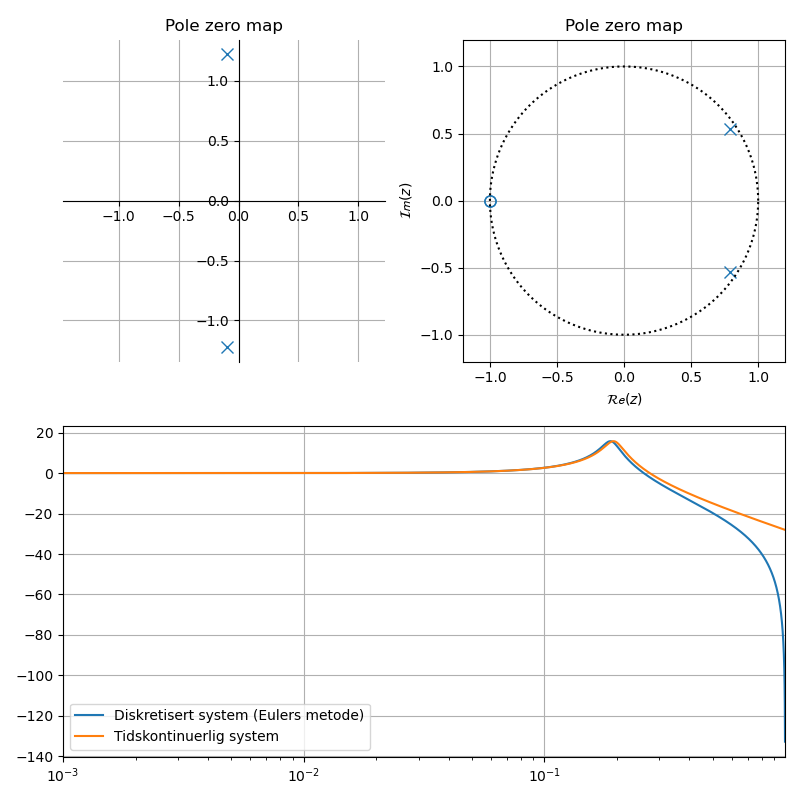

In [6]:
# Kontinuerlig system
A = np.array([[0, 1],
             [-1.5, -0.2]])
B = np.array([[0],
             [1.5]])
C = np.array([[1, 0]])
D = np.array([[0]])
sys = sig.StateSpace(A, B, C, D)

# Diskretisering (kan også utføres med scipy.signal.cont2discrete)
Ts = 0.5
ITA_inv = np.linalg.inv(np.eye(2) - A*Ts/2)
A_d = ITA_inv@(np.eye(2) + A*Ts/2)
B_d = ITA_inv@B*Ts
C_d = C@ITA_inv
D_d = D + C@B_d/2

A_d2, B_d2, C_d2, D_d2, _ = sig.cont2discrete([A, B, C, D], dt=Ts, method='bilinear')
sys_ex1 = sig.StateSpace(A_d, B_d, C_d, D_d, dt=Ts)

plt.close(5); plt.figure(5, figsize=(8,8))
#fig, axes = plt.subplots(2,2, num=2, clear=True)
plt.subplot(2,2,1)
pz_plot(sys)
plt.subplot(2,2,2)
pz_plot(sys_ex1)
plt.subplot(2,2,(3,4))
w, magd, _ = sys_ex1.bode(n=1001)
wc, magc, _ = sys.bode(w = w)
plt.plot(w/(2*pi), magd, label="Diskretisert system (Eulers metode)")
plt.plot(wc/(2*pi), magc, label="Tidskontinuerlig system")
plt.xscale("log")
plt.legend()

# Frekvensfordreining
* Tustins metode gir ulineær mapping av frekvenser

<img src="Figurer/disc_methods/freqwarp.png" style="width: 80%" />

# Forhåndsfordreining

* Metode for å tilpasse frekvens-fordreiningen slik at én spesifikk frekvens $f_p$ beholder sin plass

* Oppskrift:
    1. Kompenser for frekvensfordreining av $f_p$ ved å forhåndsfordreie samplingsfrekvensen $f_s$.
$$\lambda = \frac{\pi\cdot f_p}{\tan\left( \frac{\pi \cdot f_p}{f_s} \right) }$$
        * $\lambda$ er den "korrigerte samplingsfrekvensen" vi bruker under diskretisering
    2. Utfør tustins metode med substitusjonen
$$s \approx 2\lambda \cdot \frac{z-1}{z+1}$$

## Frekvensfordreining i Python

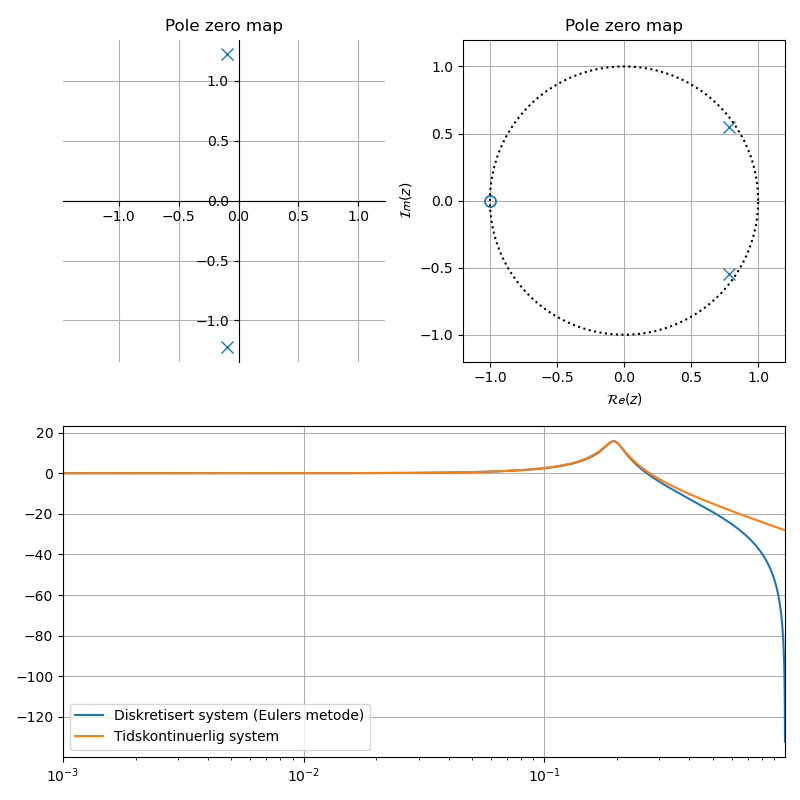

In [7]:
# Kontinuerlig system
A = np.array([[0, 1],
             [-1.5, -0.2]])
B = np.array([[0],
             [1.5]])
C = np.array([[1, 0]])
D = np.array([[0]])
sys = sig.StateSpace(A, B, C, D)

# Diskretisering (kan også utføres med scipy.signal.cont2discrete)
fp = 0.2  # Frekvens der vi ønsker å beholde eksakte egenskaper
Ts = 0.5
fs = 1/Ts
fs_prewarp = pi*fp/np.tan(pi*fp/fs)
Td = 1/fs_prewarp
ITA_inv = np.linalg.inv(np.eye(2) - A*Td/2)
A_d = ITA_inv@(np.eye(2) + A*Td/2)
B_d = ITA_inv@B*Td
C_d = C@ITA_inv
D_d = D + C@B_d/2

sys_ex1 = sig.StateSpace(A_d, B_d, C_d, D_d, dt=Ts)

plt.close(6); plt.figure(6, figsize=(8,8))
#fig, axes = plt.subplots(2,2, num=2, clear=True)
plt.subplot(2,2,1)
pz_plot(sys)
plt.subplot(2,2,2)
pz_plot(sys_ex1)
plt.subplot(2,2,(3,4))
w, magd, _ = sys_ex1.bode(n=1001)
wc, magc, _ = sys.bode(w = w)
plt.plot(w/(2*pi), magd, label="Diskretisert system (Eulers metode)")
plt.plot(wc/(2*pi), magc, label="Tidskontinuerlig system")
plt.xscale("log")
plt.legend()

# Notater om forhåndsfordreining

* Beholder kun posisjonen til én match-frekvens $f_p$
      - 2 eller flere kantfrekvenser i et system gjør det vanskeligere
* Mer nødvendig for høye frekvenser en lave
    - Tommelfingerregel:<br>forhåndsfordreining bør benyttes hvis den viktigste frekvensen $f_p$ oppfyller
$$f_p > \frac{f_s}{10}$$

# Spørsmål?